# Disease (presence of a cardiovascular disease) prediction

L’objectif de ce travail était de prédire la présence d’une maladie cardiovasculaire à partir de variables cliniques et biologiques, à l’aide de données médicales de patients.

In [ ]:
# pip install pyspark

In [1]:
# importation des librairies nécessaires

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
# Spark session
spark = SparkSession.builder.appName("MachineLearning").getOrCreate()

In [3]:
print(spark)

In [4]:
# importation des données
data = spark.read.format('csv').options(header='True', inferSchema = True).load('/content/drive/MyDrive/Colab Notebooks/Data/heart_disease.csv')

# preview données
data.limit(10).toPandas()

,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,1,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,2,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,3,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,4,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,5,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,6,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,7,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,8,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,9,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,10,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


**Les variables:**

- Age : age (years)
- Sex : gender (0 = Female, 1 = Male)
- Angina : chest pain (1 = Stable angina, 2 = Unstable angina, 3 = Other pains, 4 = Asymptomatic)
- Blood_Pressure : resting blood pressure (mmHg)
- Cholesterol : cholesterol levels (mg/dl)
- Glycemia : fasting blood sugar (0 = Less than 120 mg/dl, 1 = More than 120 mg/dl)
- ECG : electrocardiogram results (0 = Normal, 1 = Anomalies, 2 = Hypertrophy)
- Heart_Rate : maximum heart rate reached
- Angina_After_Sport : angina pectoris after physical exertion (0 = no, 1 = yes)
- ECG_Angina : measure of the angina pectoris on the electrocardiogram
- ECG_Slope : slope on the electrocardiogram (1 = Rising, 2 = Stable, 3 = Falling)
- Fluoroscopy : fluoroscopy results (0 = No anomaly, 1 = Low, 2 = Medium, 3 = High)
- Thalassemia : presence of a Thalassaemia (3 = No, 6 = Thalassaemia under control, 7 = Unstable Thalassaemia)
- Disease : presence of a cardiovascular disease (0 = No, 1/2/3/4 = Yes)

In [5]:
# trouver les valeurs manquantes

#for col_name in data.columns:
  #print(col_name, ": ", data.filter(data[col_name].isNull()).count())

for col_name in data.columns:
  print(col_name, ": ", data.filter(data[col_name] == "?").count())

ID :  0
Age :  0
Sex :  0
Angina :  0
Blood_Pressure :  0
Cholesterol :  0
Glycemia :  0
ECG :  0
Heart_Rate :  0
Angina_After_Sport :  0
ECG_Angina :  0
ECG_Slope :  0
Fluoroscopy :  4
Thalassaemia :  2
Disease :  0


In [6]:
# suppression des "?" des donnée
 # on peut imputer les valeur manquante en remplacer par le mode, mediane, ou moyenne la plus presente lorsque on a un grande nombre de NAs
 # mais dans notre cas on va juste supprimer  les "?" dans les colonnes concernées

data = data.filter((data.Fluoroscopy != "?") & (data.Thalassaemia != "?"))


In [7]:
# verification
for col_name in data.columns:
  print(col_name, ": ", data.filter(data[col_name] == "?").count())

ID :  0
Age :  0
Sex :  0
Angina :  0
Blood_Pressure :  0
Cholesterol :  0
Glycemia :  0
ECG :  0
Heart_Rate :  0
Angina_After_Sport :  0
ECG_Angina :  0
ECG_Slope :  0
Fluoroscopy :  0
Thalassaemia :  0
Disease :  0


In [8]:
data.show()

+---+----+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
| ID| Age|Sex|Angina|Blood_Pressure|Cholesterol|Glycemia|ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|Thalassaemia|Disease|
+---+----+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
|  1|63.0|1.0|   1.0|         145.0|      233.0|     1.0|2.0|     150.0|               0.0|       2.3|      3.0|        0.0|         6.0|      0|
|  2|67.0|1.0|   4.0|         160.0|      286.0|     0.0|2.0|     108.0|               1.0|       1.5|      2.0|        3.0|         3.0|      2|
|  3|67.0|1.0|   4.0|         120.0|      229.0|     0.0|2.0|     129.0|               1.0|       2.6|      2.0|        2.0|         7.0|      1|
|  4|37.0|1.0|   3.0|         130.0|      250.0|     0.0|0.0|     187.0|               0.0|       3.5|      3.0|        0.0|

In [9]:
# Recodage des modalités
# Recoding certain variables
data = data.withColumn("Sex", when(col("Sex") == 0, "Female").otherwise("Male"))
data = data.withColumn("Angina", when(col("Angina") == 1, "Stable angina").when(col("Angina") == 2, "Unstable angina").when(col("Angina") == 3, "Other pains").otherwise("Asymptomatic"))
data = data.withColumn("Glycemia", when(col("Glycemia") == 0, "Less than 120 mg/dl").otherwise("More than 120 mg/dl"))
data = data.withColumn("ECG", when(col("ECG") == 0, "Normal").when(col("ECG") == 1, "Anomalies").otherwise("Hypertrophy"))
data = data.withColumn("Angina_After_Sport", when(col("Angina_After_Sport") == 0, "No").otherwise("Yes"))
data = data.withColumn("ECG_Slope", when(col("ECG_Slope") == 1, "Rising").when(col("ECG_Slope") == 2, "Stable").otherwise("Falling"))
data = data.withColumn("Fluoroscopy", when(col("Fluoroscopy") == "0.0", "No anomaly").when(col("Fluoroscopy") == "1.0", "Low").when(col("Fluoroscopy") == "2.0", "Medium").otherwise("High"))
data = data.withColumn("Thalassaemia", when(col("Thalassaemia") == "3.0", "No").when(col("Thalassaemia") == "6.0", "Thalassaemia under control").otherwise("Unstable Thalassaemia"))
data = data.withColumn("Disease", when(col("Disease") == 0, "No").otherwise("Yes"))

# preview données
data.limit(10).toPandas()

,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,1,63.0,Male,Stable angina,145.0,233.0,More than 120 mg/dl,Hypertrophy,150.0,No,2.3,Falling,No anomaly,Thalassaemia under control,No
1,2,67.0,Male,Asymptomatic,160.0,286.0,Less than 120 mg/dl,Hypertrophy,108.0,Yes,1.5,Stable,High,No,Yes
2,3,67.0,Male,Asymptomatic,120.0,229.0,Less than 120 mg/dl,Hypertrophy,129.0,Yes,2.6,Stable,Medium,Unstable Thalassaemia,Yes
3,4,37.0,Male,Other pains,130.0,250.0,Less than 120 mg/dl,Normal,187.0,No,3.5,Falling,No anomaly,No,No
4,5,41.0,Female,Unstable angina,130.0,204.0,Less than 120 mg/dl,Hypertrophy,172.0,No,1.4,Rising,No anomaly,No,No
5,6,56.0,Male,Unstable angina,120.0,236.0,Less than 120 mg/dl,Normal,178.0,No,0.8,Rising,No anomaly,No,No
6,7,62.0,Female,Asymptomatic,140.0,268.0,Less than 120 mg/dl,Hypertrophy,160.0,No,3.6,Falling,Medium,No,Yes
7,8,57.0,Female,Asymptomatic,120.0,354.0,Less than 120 mg/dl,Normal,163.0,Yes,0.6,Rising,No anomaly,No,No
8,9,63.0,Male,Asymptomatic,130.0,254.0,Less than 120 mg/dl,Hypertrophy,147.0,No,1.4,Stable,Low,Unstable Thalassaemia,Yes
9,10,53.0,Male,Asymptomatic,140.0,203.0,More than 120 mg/dl,Hypertrophy,155.0,Yes,3.1,Falling,No anomaly,Unstable Thalassaemia,Yes


## Statistiques descriptives

### Statistique descriptives des quantitatives

In [11]:
# Statistique descriptives des quanti

data.describe().toPandas()

,summary,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,count,297,297,297,297,297,297,297,297,297,297,297,297,297,297,297
1,mean,150.67340067340066,54.54208754208754,None,None,131.69360269360268,247.35016835016836,None,None,149.5993265993266,None,1.0555555555555558,None,None,None,None
2,stddev,87.32328332326846,9.049735681096765,None,None,17.762806366598998,51.99758253513896,None,None,22.941562061360802,None,1.1661227818468953,None,None,None,None
3,min,1,29.0,Female,Asymptomatic,94.0,126.0,Less than 120 mg/dl,Anomalies,71.0,No,0.0,Falling,High,No,No
4,max,302,77.0,Male,Unstable angina,200.0,564.0,More than 120 mg/dl,Normal,202.0,Yes,6.2,Stable,No anomaly,Unstable Thalassaemia,Yes


Observations :

La moyenne d'âge autour de 54 ans est typique pour les études cardiovasculaires.

Il y a une grande variabilité du cholestérol et de la pression artérielle → à surveiller, il peut y avoir des valeurs extrêmes (outliers).

ECG_Angina semble varier jusqu'à 6.2, ce qui pourrait indiquer une échelle continue (tu peux vérifier si une normalisation est utile avant modélisation).

In [12]:
data.select("Age").summary().show()
data.select("Blood_Pressure").summary().show()
data.select("Cholesterol").summary().show()
data.select("Heart_Rate").summary().show()

# 50% represente la mediane un groupe à moinS de 56 ans et l'autre plus de 56 ans

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|              297|
|   mean|54.54208754208754|
| stddev|9.049735681096765|
|    min|             29.0|
|    25%|             48.0|
|    50%|             56.0|
|    75%|             61.0|
|    max|             77.0|
+-------+-----------------+

+-------+------------------+
|summary|    Blood_Pressure|
+-------+------------------+
|  count|               297|
|   mean|131.69360269360268|
| stddev|17.762806366598998|
|    min|              94.0|
|    25%|             120.0|
|    50%|             130.0|
|    75%|             140.0|
|    max|             200.0|
+-------+------------------+

+-------+------------------+
|summary|       Cholesterol|
+-------+------------------+
|  count|               297|
|   mean|247.35016835016836|
| stddev| 51.99758253513896|
|    min|             126.0|
|    25%|             211.0|
|    50%|             243.0|
|    75%|             276.0|
|    max|             56

**Âge**:

- L’âge médian est légèrement supérieur à la moyenne → distribution légèrement asymétrique vers la gauche (quelques jeunes abaissent la moyenne).
- Pas de valeur extrême manifeste (29 à 77 ans est plausible pour des patients cardiovasculaires).

**Blood_Pressure (Pression artérielle au repos)**:
- Distribution assez symétrique (moyenne ≈ médiane).
- La majorité des patients ont une pression normale/élevée.
- Max = 200 mmHg → possible outlier (très haute pression → cas sévère).

**Cholesterol**:

- Moyenne et médiane proches → distribution assez symétrique.
-Max = 564 mg/dl → clairement un outlier, possiblement un cas pathologique.
- Quartiles montrent une répartition raisonnable, mais les valeurs extrêmes doivent être considérées dans l’analyse.

**Heart_Rate (Fréquence cardiaque maximale atteinte)**:

- Légère asymétrie droite (moyenne < médiane).
- Min = 71 bpm peut indiquer des conditions physiques faibles ou un cas clinique particulier.
- Pas d'outlier évident, mais extrêmes (71 ou 202) peuvent influencer certains modèles.

**Conclusion sur les variables continues** :

Pas de données aberrantes à supprimer, mais certaines extrêmes (cholestérol > 500, pression > 180, etc.) peuvent être traitées avec précaution.

Envisage éventuellement une normalisation / standardisation avant modélisation (selon le modèle choisi).

### Statistiques des variables catégorielles

In [13]:
data.groupBy("Disease").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()
data.groupBy("Sex").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()
data.groupBy("Angina").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()
data.groupBy("Glycemia").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()

+-------+-----+-----------+
|Disease|count|Pourcentage|
+-------+-----+-----------+
|     No|  160|      53.87|
|    Yes|  137|      46.13|
+-------+-----+-----------+

+------+-----+-----------+
|   Sex|count|Pourcentage|
+------+-----+-----------+
|Female|   96|      32.32|
|  Male|  201|      67.68|
+------+-----+-----------+

+---------------+-----+-----------+
|         Angina|count|Pourcentage|
+---------------+-----+-----------+
|    Other pains|   83|      27.95|
|Unstable angina|   49|       16.5|
|  Stable angina|   23|       7.74|
|   Asymptomatic|  142|      47.81|
+---------------+-----+-----------+

+-------------------+-----+-----------+
|           Glycemia|count|Pourcentage|
+-------------------+-----+-----------+
|More than 120 mg/dl|   43|      14.48|
|Less than 120 mg/dl|  254|      85.52|
+-------------------+-----+-----------+



**Disease (Variable cible)**:
- Répartition assez équilibrée → pas besoin de sur/undersampling.
- Bonne base pour une classification binaire : 0 = Non malade, 1 = Malade (fusionner les classes 1 à 4).
- Cela signifie que ton modèle ne sera pas trop biaisé par une classe majoritaire, ce qui est rare en santé !

**Sex(Sexe)**
 - Il y a deux fois plus d'hommes que de femmes dans ton dataset
 - Explorer si la variable Sex a un impact significatif sur Disease → possible biais de genre à détecter

**Angina (Douleurs thoraciques)**:
  - Près de la moitié des patients sont asymptomatiques → les cas les plus "à risque" peuvent passer inaperçus.
  - Cela peut rendre la prédiction plus difficile, car certaines personnes malades n’ont aucun symptôme évident.

**Glycemia (Glycémie à jeun)**:
- Une large majorité ont une glycémie normale.
- vérifier si ceux avec une glycémie élevée ont un risque cardiovasculaire plus élevé → corrélation potentielle à explorer.


Un dataset équilibré en termes de maladie (Disease),

Des variables catégorielles prêtes à être encodées,


## Analyse des relations entre variables (bilaterale)

In [14]:
# tableau croisé des variable catégorielle

data.groupBy("Sex", "Disease").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()
data.groupBy("Angina", "Disease").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()
data.groupBy("Glycemia", "Disease").count().withColumn("Pourcentage", round((col("count") / data.count())* 100, 2)).show()

+------+-------+-----+-----------+
|   Sex|Disease|count|Pourcentage|
+------+-------+-----+-----------+
|  Male|     No|   89|      29.97|
|  Male|    Yes|  112|      37.71|
|Female|     No|   71|      23.91|
|Female|    Yes|   25|       8.42|
+------+-------+-----+-----------+

+---------------+-------+-----+-----------+
|         Angina|Disease|count|Pourcentage|
+---------------+-------+-----+-----------+
|   Asymptomatic|     No|   39|      13.13|
|  Stable angina|     No|   16|       5.39|
|  Stable angina|    Yes|    7|       2.36|
|   Asymptomatic|    Yes|  103|      34.68|
|    Other pains|     No|   65|      21.89|
|Unstable angina|     No|   40|      13.47|
|    Other pains|    Yes|   18|       6.06|
|Unstable angina|    Yes|    9|       3.03|
+---------------+-------+-----+-----------+

+-------------------+-------+-----+-----------+
|           Glycemia|Disease|count|Pourcentage|
+-------------------+-------+-----+-----------+
|More than 120 mg/dl|    Yes|   20|       6.73

**Sexe vs Maladie (Sex vs Disease)**:
- En proportion, les hommes sont plus touchés par la maladie cardiovasculaire.
- Cela confirme ce qu’on observe souvent en cardiologie : le risque cardiovasculaire est plus élevé chez les hommes, surtout à partir de 50 ans.

**Type de douleur thoracique (Angina vs Disease)**:
- Asymptomatique = signal fort de maladie → important ! Cela montre que l’absence de douleur n’exclut pas la maladie, et ces cas sont souvent les plus risqués car non détectés.
- À l’inverse, les douleurs "non typiques" ou "instables" sont souvent non liées à la maladie (potentiellement des douleurs musculaires ou gastriques).

**Glycémie (Glycemia vs Disease)**:
- Contrairement à ce qu’on pourrait croire, la glycémie à jeun n’est pas très discriminante ici.
- Il faudrait peut-être creuser avec d’autres variables métaboliques (IMC, triglycérides, etc.) pour mieux cerner le risque métabolique.

**insights clés** :

- Sex : Les hommes sont beaucoup plus à risque que les femmes.
- Angina: Les patients asymptomatiques sont souvent malades, ce qui est critique pour la détection précoce.
- Glycémie:	Pas très discriminante dans ce dataset

In [15]:
# Moyenne des variable quantitative base sur disease

data.groupBy("Disease").agg(round(mean('Age'), 2).alias(' Age Average')).show()
data.groupBy("Disease").agg(round(mean('Blood_Pressure'), 2).alias(' Blood_Pressure Average')).show()
data.groupBy("Disease").agg(mean('Cholesterol')).show()

+-------+------------+
|Disease| Age Average|
+-------+------------+
|     No|       52.64|
|    Yes|       56.76|
+-------+------------+

+-------+-----------------------+
|Disease| Blood_Pressure Average|
+-------+-----------------------+
|     No|                 129.18|
|    Yes|                 134.64|
+-------+-----------------------+

+-------+------------------+
|Disease|  avg(Cholesterol)|
+-------+------------------+
|     No|         243.49375|
|    Yes|251.85401459854015|
+-------+------------------+



**Âge moyen**:
- Les patients malades sont en moyenne plus âgés de 4 ans.
- C’est cohérent avec la littérature médicale : le risque cardiovasculaire augmente fortement avec l’âge.
- L'âge est donc un facteur important à inclure dans le modèle.

**Pression artérielle moyenne**:
- Les patients malades ont une pression artérielle plus élevée en moyenne.
- Bien que la différence soit modérée (~5 mmHg), elle est cliniquement significative.
- Cela renforce le rôle de la pression artérielle comme facteur de risque cardiovasculaire.

**Cholestérol moyen**:
- Les malades ont en moyenne un cholestérol plus élevé de ~8 mg/dl.
- Ce n’est pas une énorme différence, mais combinée à d’autres facteurs, elle peut devenir significative.
- Encore une fois, cela confirme la relation bien connue entre hypercholestérolémie et maladies cardiovasculaires.

- L’âge est un facteur clair de risque
- Pression plus élevée chez les malades
- Légèrement plus élevé chez les malades

 Ces différences renforcent la pertinence de ces variables pour la modélisation

## Preprocessing pour ML

In [16]:
# transformation des colonnes catégorielle en colonne binaires

from pyspark.ml.feature import StringIndexer, VectorAssembler
#from pyspark.ml import Pipeline

In [17]:
# preview données
data.limit(5).toPandas()

,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,1,63.0,Male,Stable angina,145.0,233.0,More than 120 mg/dl,Hypertrophy,150.0,No,2.3,Falling,No anomaly,Thalassaemia under control,No
1,2,67.0,Male,Asymptomatic,160.0,286.0,Less than 120 mg/dl,Hypertrophy,108.0,Yes,1.5,Stable,High,No,Yes
2,3,67.0,Male,Asymptomatic,120.0,229.0,Less than 120 mg/dl,Hypertrophy,129.0,Yes,2.6,Stable,Medium,Unstable Thalassaemia,Yes
3,4,37.0,Male,Other pains,130.0,250.0,Less than 120 mg/dl,Normal,187.0,No,3.5,Falling,No anomaly,No,No
4,5,41.0,Female,Unstable angina,130.0,204.0,Less than 120 mg/dl,Hypertrophy,172.0,No,1.4,Rising,No anomaly,No,No


In [18]:
##  conversion des variables catégorielles en variable numerique  on renomme la variable cible 'label'
indexer1 = StringIndexer(inputCol="Sex", outputCol="Sex_Index")
indexer2 = StringIndexer(inputCol="Angina", outputCol="Angina_Index")
indexer3 = StringIndexer(inputCol="Glycemia", outputCol="Glycemia_Index")
indexer4 = StringIndexer(inputCol="ECG", outputCol="ECG_Index")
indexer5 = StringIndexer(inputCol="Angina_After_Sport", outputCol="Angina_After_Sport_Index")
indexer6 = StringIndexer(inputCol="ECG_Slope", outputCol="ECG_Slope_Index")
indexer7 = StringIndexer(inputCol="Fluoroscopy", outputCol="Fluoroscopy_Index")
indexer8 = StringIndexer(inputCol="Thalassaemia", outputCol="Thalassaemia_Index")
indexer9 = StringIndexer(inputCol="Disease", outputCol="label")

In [19]:
# assembler feature columns into a feature vector

assembler = VectorAssembler(
    inputCols=["Sex_Index", "Angina_Index", "Glycemia_Index", "ECG_Index", "Angina_After_Sport_Index", "ECG_Slope_Index", "Fluoroscopy_Index", "Thalassaemia_Index", "Age", "Blood_Pressure", "Cholesterol", "Heart_Rate", "ECG_Angina"],
    outputCol="features"
)

# ML modèles

In [20]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [21]:
# logistic regression

lr = LogisticRegression()

## Pipeline definition

pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, indexer6, indexer7, indexer8, indexer9, assembler, lr])


## Split data train et test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 123)

## Train model

model = pipeline.fit(train_data)


## Prédiction

In [26]:
train_data.toPandas()

,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,1,63.0,Male,Stable angina,145.0,233.0,More than 120 mg/dl,Hypertrophy,150.0,No,2.3,Falling,No anomaly,Thalassaemia under control,No
1,2,67.0,Male,Asymptomatic,160.0,286.0,Less than 120 mg/dl,Hypertrophy,108.0,Yes,1.5,Stable,High,No,Yes
2,4,37.0,Male,Other pains,130.0,250.0,Less than 120 mg/dl,Normal,187.0,No,3.5,Falling,No anomaly,No,No
3,5,41.0,Female,Unstable angina,130.0,204.0,Less than 120 mg/dl,Hypertrophy,172.0,No,1.4,Rising,No anomaly,No,No
4,6,56.0,Male,Unstable angina,120.0,236.0,Less than 120 mg/dl,Normal,178.0,No,0.8,Rising,No anomaly,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,296,41.0,Male,Unstable angina,120.0,157.0,Less than 120 mg/dl,Normal,182.0,No,0.0,Rising,No anomaly,No,No
206,297,59.0,Male,Asymptomatic,164.0,176.0,More than 120 mg/dl,Hypertrophy,90.0,No,1.0,Stable,Medium,Thalassaemia under control,Yes
207,300,68.0,Male,Asymptomatic,144.0,193.0,More than 120 mg/dl,Normal,141.0,No,3.4,Stable,Medium,Unstable Thalassaemia,Yes
208,301,57.0,Male,Asymptomatic,130.0,131.0,Less than 120 mg/dl,Normal,115.0,Yes,1.2,Stable,Low,Unstable Thalassaemia,Yes


In [23]:
test_data.toPandas(5)

,ID,Age,Sex,Angina,Blood_Pressure,Cholesterol,Glycemia,ECG,Heart_Rate,Angina_After_Sport,ECG_Angina,ECG_Slope,Fluoroscopy,Thalassaemia,Disease
0,3,67.0,Male,Asymptomatic,120.0,229.0,Less than 120 mg/dl,Hypertrophy,129.0,Yes,2.6,Stable,Medium,Unstable Thalassaemia,Yes
1,7,62.0,Female,Asymptomatic,140.0,268.0,Less than 120 mg/dl,Hypertrophy,160.0,No,3.6,Falling,Medium,No,Yes
2,10,53.0,Male,Asymptomatic,140.0,203.0,More than 120 mg/dl,Hypertrophy,155.0,Yes,3.1,Falling,No anomaly,Unstable Thalassaemia,Yes
3,13,56.0,Male,Other pains,130.0,256.0,More than 120 mg/dl,Hypertrophy,142.0,Yes,0.6,Stable,Low,Thalassaemia under control,Yes
4,14,44.0,Male,Unstable angina,120.0,263.0,Less than 120 mg/dl,Normal,173.0,No,0.0,Rising,No anomaly,Unstable Thalassaemia,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,290,56.0,Male,Unstable angina,120.0,240.0,Less than 120 mg/dl,Normal,169.0,No,0.0,Falling,No anomaly,No,No
83,291,67.0,Male,Other pains,152.0,212.0,Less than 120 mg/dl,Hypertrophy,150.0,No,0.8,Stable,No anomaly,Unstable Thalassaemia,Yes
84,294,63.0,Male,Asymptomatic,140.0,187.0,Less than 120 mg/dl,Hypertrophy,144.0,Yes,4.0,Rising,Medium,Unstable Thalassaemia,Yes
85,298,57.0,Female,Asymptomatic,140.0,241.0,Less than 120 mg/dl,Normal,123.0,Yes,0.2,Stable,No anomaly,Unstable Thalassaemia,Yes


In [29]:
rows_train = train_data.count()
cols_train = len(train_data.columns)
print(f"Les données train : ({rows_train}, {cols_train})")

rows_test = test_data.count()
cols_test = len(test_data.columns)
print(f"Les données test : ({rows_test}, {cols_test})")


Les données train : (210, 15)
Les données test : (87, 15)


In [30]:
# prédiction sur les données  test

predictions = model.transform(test_data)

# preview of prediction  compared to actual values
predictions_pd = predictions.select("label", "prediction")
predictions_pd.toPandas()

,label,prediction
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
...,...,...
82,0.0,0.0
83,1.0,1.0
84,1.0,1.0
85,1.0,0.0


# Analyse de performance du modèle

In [31]:
 # Model accuracy calculation
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)



Accuracy: 0.8390804597701149


In [32]:
print("Accuracy: {: .2f}%".format(accuracy *100))

Accuracy:  83.91%


**Résultats du modèle**:
- Accuracy : 83.91 %

Très bon score global ! Ton modèle prédit correctement environ 84% des cas.

In [38]:
# Matrice de confusion

#predictions.select("label", "prediction").crosstab("label", "prediction").show()

In [37]:
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   36|
|  0.0|       1.0|    7|
|  1.0|       0.0|    7|
|  1.0|       1.0|   37|
+-----+----------+-----+



Interprétation :

- 36 vrais négatifs : patients sains bien prédits
- 37 vrais positifs : patients malades bien détectés
- 7 faux positifs : patients sains faussement diagnostiqués malades
- 7 faux négatifs : patients malades non détectés ❗

Le modèle est bien équilibré, avec un taux d’erreurs faibles et symétriques : il détecte à peu près aussi bien les malades que les non malades.

In [34]:
# F1 Score
f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions)

# Precision
precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="precisionByLabel").evaluate(predictions)

# Recall
recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="recallByLabel").evaluate(predictions)

print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")


F1 Score  : 0.8391
Precision : 0.8372
Recall    : 0.8372


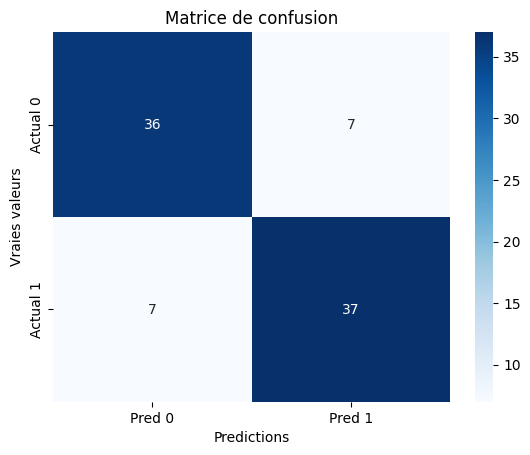

In [35]:
from sklearn.metrics import confusion_matrix

# Convertir en Pandas
predictions_pd = predictions.select("label", "prediction").toPandas()

# Créer la matrice
cm = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()


**Précision : 83.72 %**

Sur tous les patients prédits comme malades, 83.72 % le sont réellement.

- Bonne capacité du modèle à éviter les faux positifs.
- C’est important pour ne pas sur-diagnostiquer inutilement des personnes saines.


**Recall (Sensibilité) : 83.72 %**

Sur tous les vrais malades, 83.72 % ont été correctement détectés.

- Très bon taux de détection.
- C’est crucial dans un contexte médical, car rater un malade (faux négatif) peut avoir de graves conséquences.


**F1-Score : 0.8391**

Moyenne harmonique entre précision et rappel.

- Bon équilibre entre détection correcte et minimisation des erreurs.
- Le modèle est robuste et fiable pour un premier niveau de screening.

Conclusion globale :

Prédit la maladie avec une bonne précision (84 %),

Équilibre bien entre les deux classes (malades / non malades),

Limite autant que possible les erreurs critiques (faux négatifs).

✅ C’est un modèle solide qui peut servir d’outil d’aide à la décision ou de base pour une application de prédiction médicale.